# AOS: calculating OPD metrics - FWHM and PSSN 

Optical Path Difference and wavefront error (WFE) are just two different names for the same error - the deviation of the true wavefront from the perfectly spherical wavefront :
    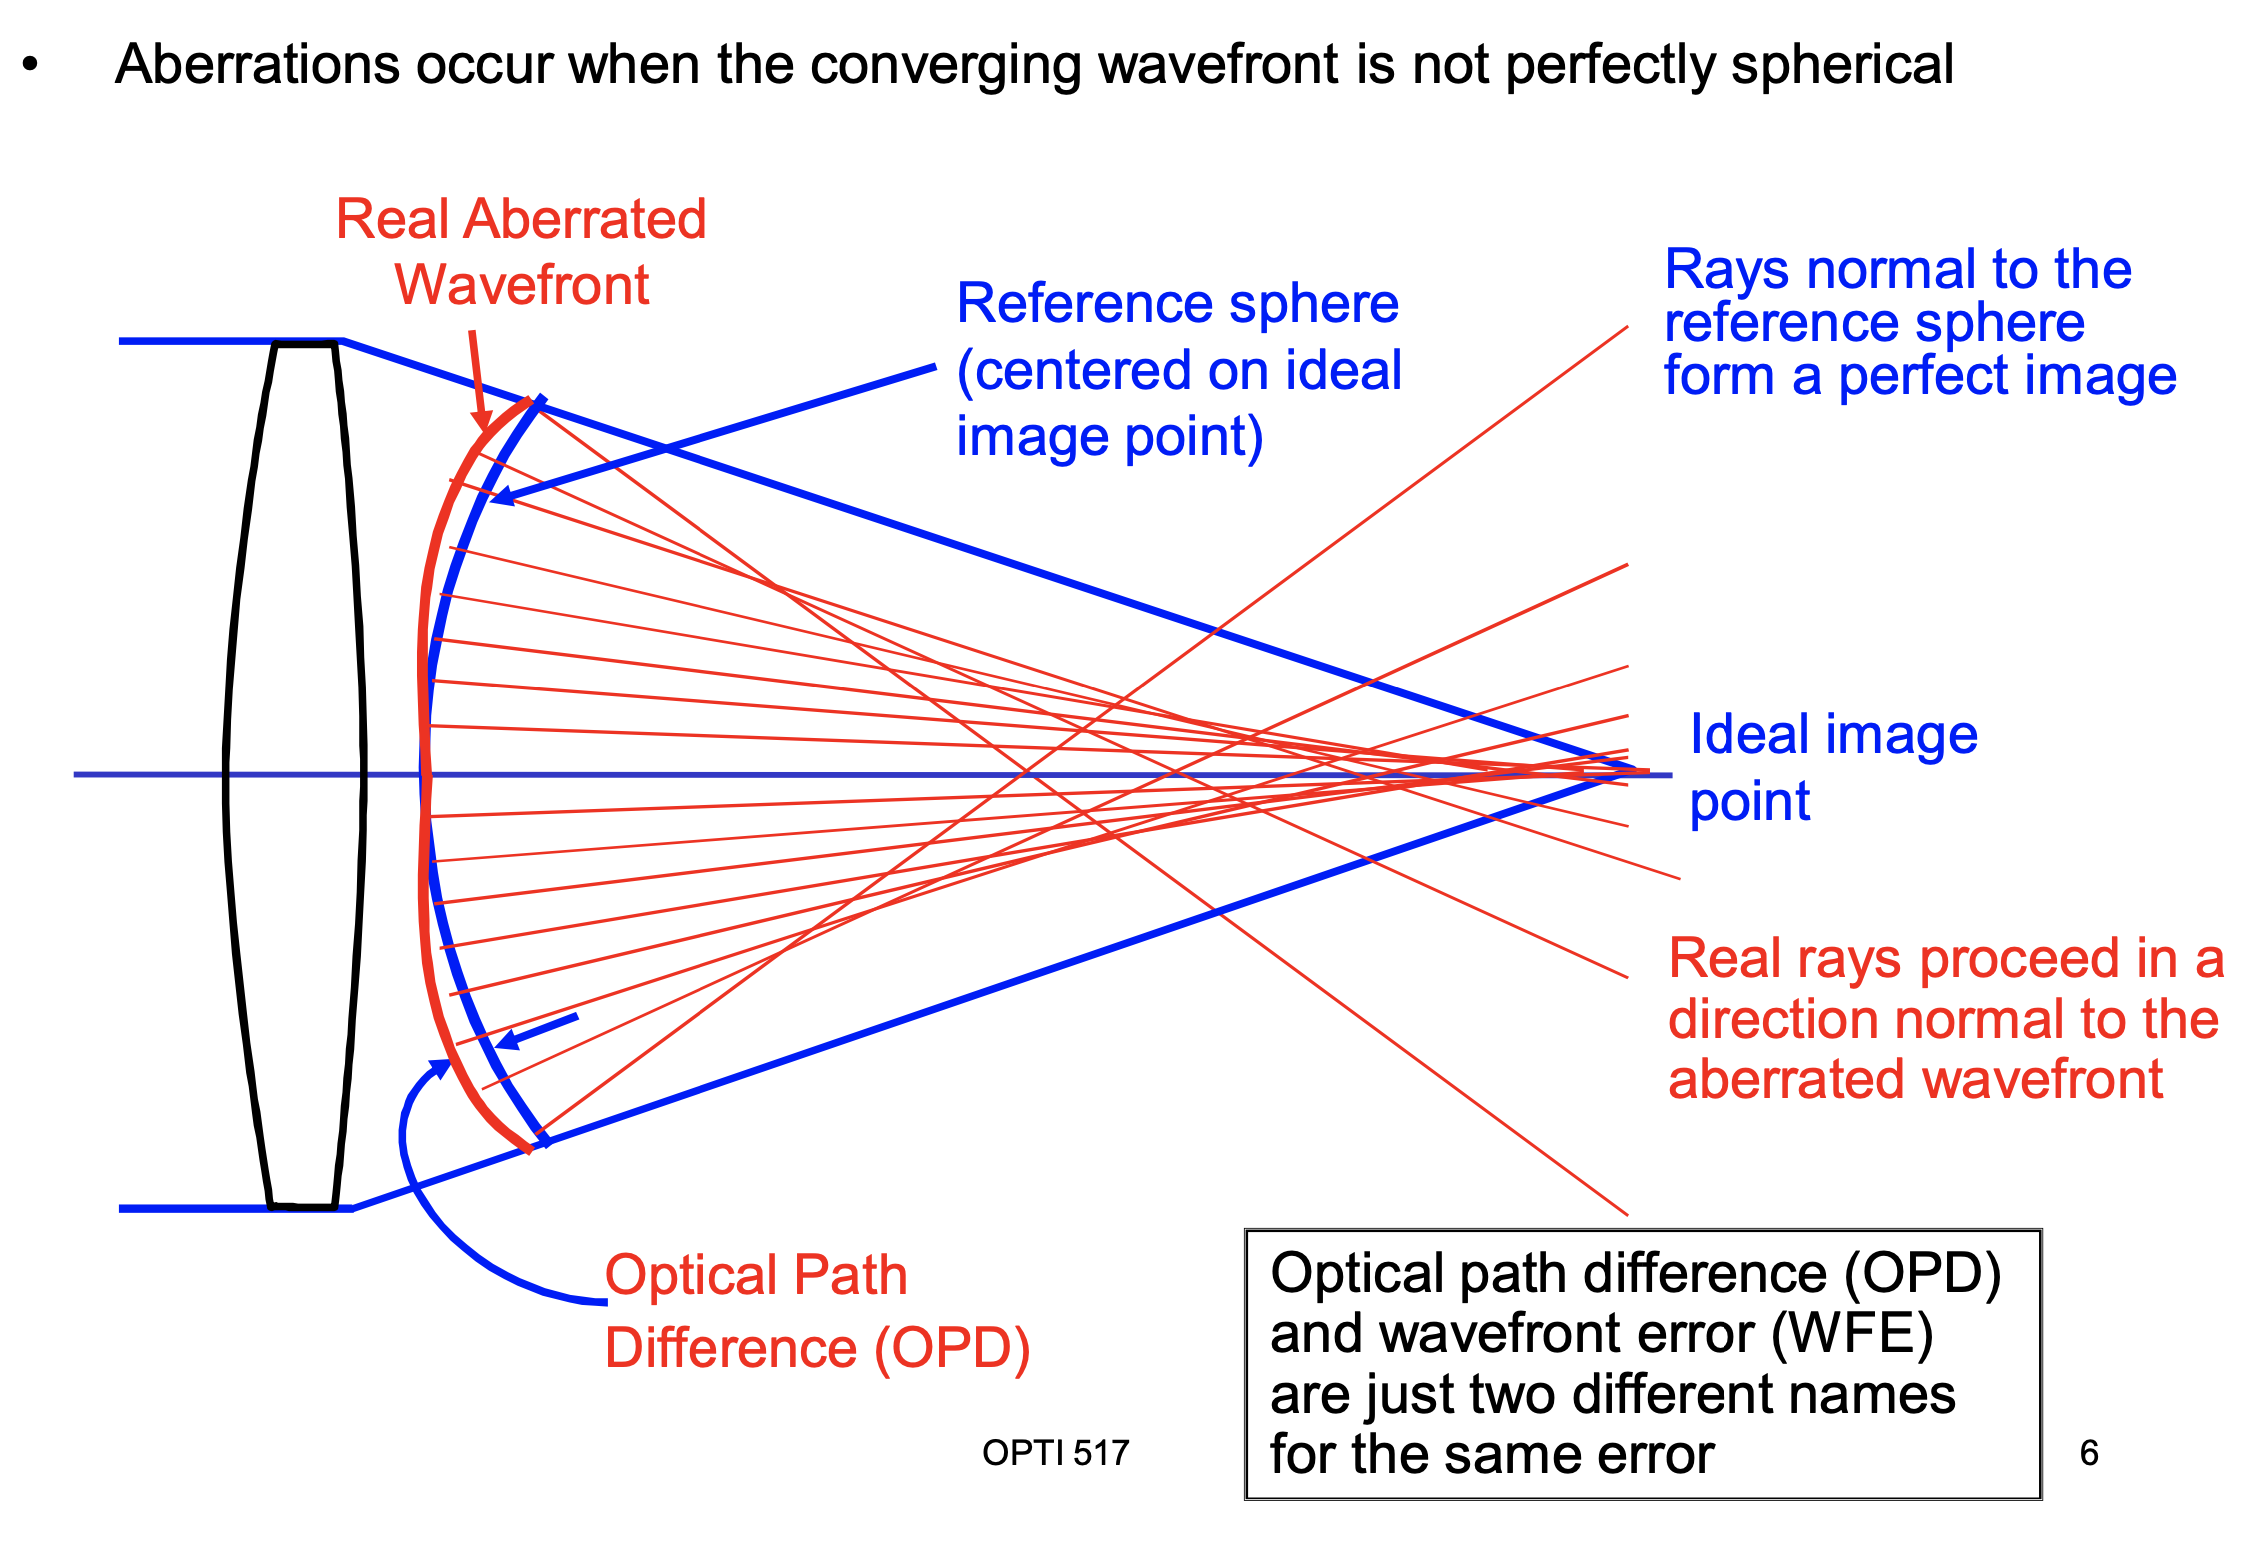
    
Then in the AOS loop we often plot the OPD (wavefront error) as this 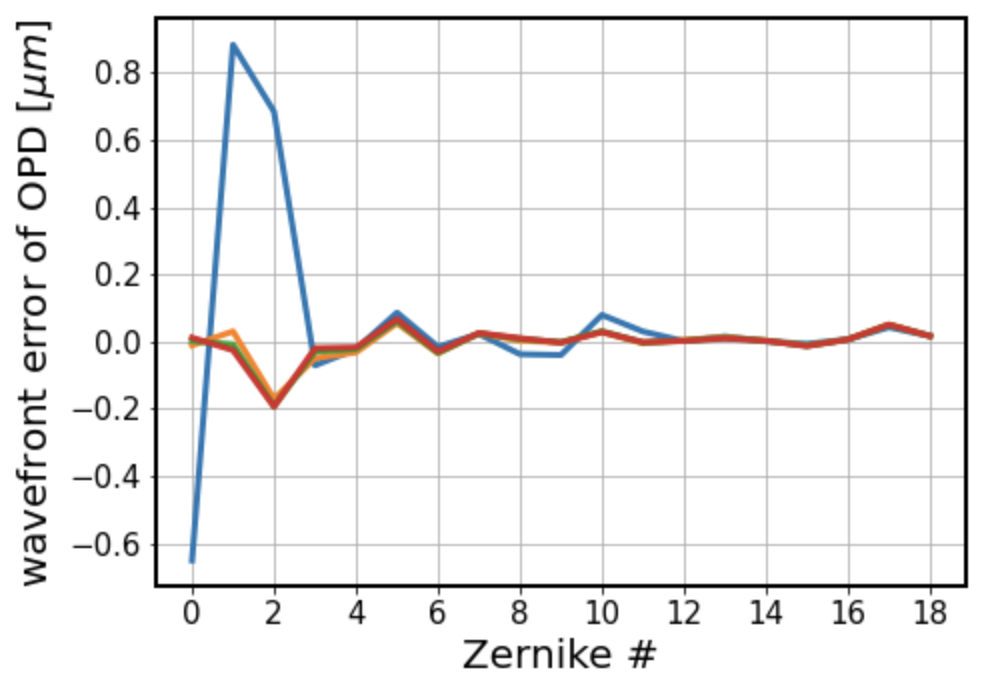. We plot here the content of  `opdData =  'iterN/img/opd.zer'`  as `np.mean(opdData, axis=0)`, with the mean taken across the places where OPD was evaluated (eg. 9 CCD centers for comCam, or 31 field locations for lsstComCam). The label should actually say "wavefront error (OPD)" (update `analysisTools.py`). 

Given that, a perfect telescope that does not affect the wavefront in any way would have zero OPD, and PSSN=1 - see comment in https://github.com/lsst-ts/ts_phosim/blob/f55c6b27b1df4b8d0fbad541f9fb3b1934a57fd7/python/lsst/ts/phosim/utils/MetroTool.py#L135 

The documents that talk about PSSN:
* "Optical Performance of LSST Primary-Tertiary Mirror" https://docushare.lsstcorp.org/docushare/dsweb/Get/Document-17171 and 
* "Normalized Point Source Sensitivity for LSST" https://docushare.lsst.org/docushare/dsweb/Get/Document-17242/PSSN%20for%20LSST%20v12.pdf

Take OPD and the calculated PSSN, FWHM values from a simulation. This is running the baseline for comcam:

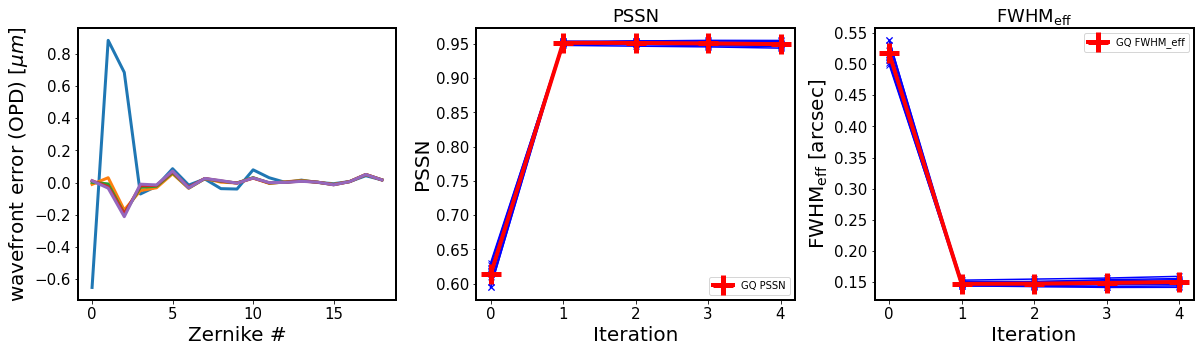

In [2]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

# common functions for AOS analysis
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
path_to_project = '/sdf/group/rubin/ncsa-project/project/scichris/aos'
path_to_dir ='refcats_DM-34547/imgCloseLoop2/'

data_dir = os.path.join(path_to_project, path_to_dir)

iterNum=5
num_ccds = 9 
testLabel=''
opdPssnFileName='PSSN.txt'

opdDataDic = {}
wfsDataDic = {}
pssn_data = []
fwhm_data = []
opdOnly=True
for iterCount in range(iterNum):
    # load the OPD data 
    opdZkFilePath = os.path.join(data_dir,  'iter%d/img/opd.zer%s'%(iterCount,
                                                                     testLabel))
    opdData = np.loadtxt(opdZkFilePath)
    opdDataDic[iterCount] = opdData

#     if not opdOnly:
#         # load the wavefront error data 
#         wfsZkFilePath = os.path.join(data_dir,  'iter%d/img/wfs.zer%s'%(iterCount,
#                                                                      testLabel))
#         wfsData = np.loadtxt(wfsZkFilePath)
#         wfsDataDic[iterCount] = wfsData

    # load the PSSN and FWHM data 
    pssn_filename = os.path.join(data_dir, 'iter%i' % iterCount, 
                                 'img/%s'%opdPssnFileName)
    pssn_file_array = np.genfromtxt(pssn_filename)
    pssn_data.append(pssn_file_array[0])
    fwhm_data.append(pssn_file_array[1])
pssn_data = np.array(pssn_data)
fwhm_data = np.array(fwhm_data)

if not opdOnly:
    fig,axs = plt.subplots(2,2,figsize=(16,12)
                        )
else:
    fig,axs = plt.subplots(1,3,figsize=(20,5)
                        )
ax = np.ravel(axs)

# 0: plot the OPD 

# to compare the two, need  to somehow "average" the OPD ? 
# plot the values of zernikes at different field points...
k = 0 
for iterCount in range(iterNum):
    opdData = opdDataDic[iterCount]
#     for i in range(np.shape(opdData)[0]):
#         ax.plot(opdData[i,:], lw=1,ls='--')
    # plot the average of these ... 
    ax[k].plot(np.mean(opdData, axis=0), lw=3,ls='-' ,)

ax[k].set_xlabel('Zernike #')
ax[k].set_ylabel('wavefront error (OPD) '+r'$[\mu m]$')

# 2: plot PSSN 
k += 1 
for i in range(num_ccds):
    ax[k].plot(np.arange(iterNum), pssn_data[:,i], c='b', marker='x')
ax[k].plot(np.arange(iterNum), pssn_data[:,num_ccds], lw=4, marker='+',
         ms=20, markeredgewidth=5, c='r', label='GQ PSSN')
ax[k].legend()
ax[k].set_xlabel('Iteration')
ax[k].set_ylabel('PSSN')
ax[k].set_title('PSSN')
# plt.xticks(size=14)
# plt.yticks(size=14)


# 3: plot the FWHM 
k +=1 
for i in range(num_ccds):
    ax[k].plot(np.arange(iterNum), fwhm_data[:,i], c='b', marker='x')
ax[k].plot(np.arange(iterNum), fwhm_data[:,num_ccds], lw=4, marker='+',
         ms=20, markeredgewidth=5, c='r', label='GQ FWHM_eff')
ax[k].legend()
ax[k].set_xlabel('Iteration')
ax[k].set_ylabel(r'$\mathrm{FWHM}_{\mathrm{eff}}$ [arcsec]')
ax[k].set_title(r'$\mathrm{FWHM}_{\mathrm{eff}}$')
# plt.xticks(size=14)
# plt.yticks(size=14)
fig.subplots_adjust(wspace=0.25)

PSSN is calculated based on the OPD data: `CloseLoopTask` calls [`PhosimCmpt.analyzeOpdData`](https://github.com/lsst-ts/ts_phosim/blob/2a06807d495eb21e38aac196b0c88d6842de0f72/python/lsst/ts/phosim/CloseLoopTask.py#L582). This calls [_writeOpdPssnFile](https://github.com/lsst-ts/ts_phosim/blob/2a06807d495eb21e38aac196b0c88d6842de0f72/python/lsst/ts/phosim/PhosimCmpt.py#L1033), calling [_calcPssnOpd](https://github.com/lsst-ts/ts_phosim/blob/2a06807d495eb21e38aac196b0c88d6842de0f72/python/lsst/ts/phosim/PhosimCmpt.py#L1071), calling [calcPSSN](https://github.com/lsst-ts/ts_phosim/blob/bf49b3865aaa4563948a262d8c6a40ccee63eb2e/python/lsst/ts/phosim/OpdMetrology.py#L364) in `OpdMetrology`, which calls [calc_pssn](https://github.com/lsst-ts/ts_phosim/blob/bf49b3865aaa4563948a262d8c6a40ccee63eb2e/python/lsst/ts/phosim/utils/MetroTool.py#L29) in `MetroTool`  

It appears that to the perfect telescope, the only element added is the atmosphere with Von Karman power spectrum ([modulation transfer function](https://github.com/lsst-ts/ts_phosim/blob/bf49b3865aaa4563948a262d8c6a40ccee63eb2e/python/lsst/ts/phosim/utils/MetroTool.py#L115), so that 

OPD --> PSF --> Optical Transfer Function

## Trace the steps of calculating PSSN based on OPD:

In [21]:
import re
from lsst.ts.phosim.utils.Utility import getConfigDir, sortOpdFileList

iterNum = 4
opdDir = os.path.join(data_dir, f'iter{iterNum}/img' )

def _getFileInDir(fileDir):
    """Get the files in the directory.
    Parameters
    ----------
    fileDir : str
        File directory.
    Returns
    -------
    list
        List of files.
    """

    fileList = []
    for name in os.listdir(fileDir):
        filePath = os.path.join(fileDir, name)
        if os.path.isfile(filePath):
            fileList.append(filePath)

    return fileList

# _getOpdFileInDir in PhosimCmpt
opdFileList = []
fileList = _getFileInDir(opdDir)
for file in fileList:
    fileName = os.path.basename(file)
    m = re.match(r"\Aopd_\d+_(\d+).fits.gz", fileName)
    if m is not None:
        opdFileList.append(file)

# _calcPssnOpd  in PhosimCmpt

# Do the sorting of file name
sortedOpdFileList = sortOpdFileList(opdFileList)

       
# the reference filter is defined as 500 nm,
# in https://github.com/lsst-ts/ts_phosim/blob/develop/policy/teleSetting.yaml 
wavelengthInUm = 500 * 1e-3

# pssnList = []
# for opdFile in opdFileList:
#     pssn = self.metr.calcPSSN(wavelengthInUm, opdFitsFile=opdFile)
#     pssnList.append(pssn)

# do calculation for the first file 
opdFile = opdFileList[0]


In [23]:
from lsst.ts.phosim.OpdMetrology import OpdMetrology
metr = OpdMetrology()
metr.setCamera('comcam')

In [27]:
# in OpdMetrology  calcPSSN, we first 
# remove the piston, and x,y-tilts
opdRmPTT = metr.rmPTTfromOPD(opdFitsFile=opdFile, opdMap=None)[0]

In [43]:
opdFile

'/sdf/group/rubin/ncsa-project/project/scichris/aos/refcats_DM-34547/imgCloseLoop2/iter4/img/opd_9006040_8.fits.gz'

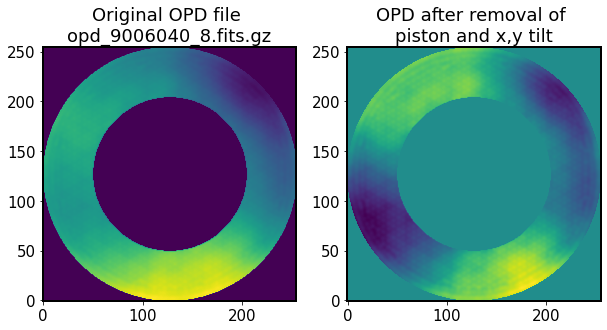

In [42]:
from astropy.io import fits
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title(f'Original OPD file \n{opdFile.split("/")[-1]}')
ax[0].imshow(fits.getdata(opdFile), origin='lower')

ax[1].set_title('OPD after removal of \npiston and x,y tilt')
ax[1].imshow(opdRmPTT,origin='lower')

The image on the right is fed to `calc_pssn` : 
    
       pssn = calc_pssn(opdRmPTT, wavelengthInUm, zen=zen, debugLevel=debugLevel)
        

In [46]:
# According to the `starPhosimlog` file , the zenith angle in this 
# simulation was 36.7557 

zAngleInDeg = 36.7557  # zenith angle  default value  

# Now calc_pssn renames some variables
array = opdRmPTT
wlum = wavelengthInUm
aType="opd"
D=8.36 #  Side length of OPD image in meter 
r0inmRef=0.1382 # Fidicial atmosphere r0 @ 500nm in meter, Konstantinos uses 0.20.
zen=zAngleInDeg # Telescope zenith angle in degree.
pmask=0 
imagedelta=0
fno=1.2335
debugLevel=3



In [50]:
# Squeeze the array if necessary
if array.ndim == 3:
    array2D = array[0, :, :].squeeze()

# Get the k value (magnification ratio used in creating MTF)
#  if aType == "opd":
# if array2D doesn't exist since ndim == 2 : 
m = max(array.shape)
k = 1

In [53]:
from lsst.ts.phosim.utils import MetroTool
# Get the modulation transfer function with the van Karman power spectrum
mtfa = MetroTool.createMTFatm(D, m, k, wlum, zen, r0inmRef, model="vonK")

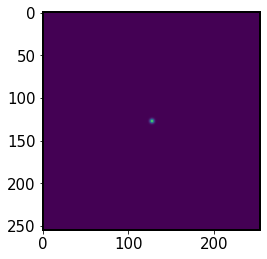

In [55]:
plt.imshow(mtfa)

In [56]:
# Get the pupil function
if aType == "opd":
    try:
        iad = array2D != 0
    except NameError:
        iad = array != 0
elif aType == "psf":
    # Add even number
    mk = int(m + np.rint((m * (k - 1) + 1e-5) / 2) * 2)
    # padArray(pmask, m)
    iad = pmask


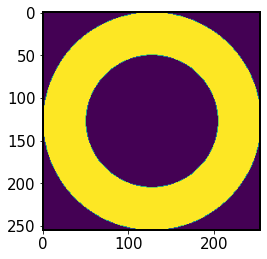

In [58]:
plt.imshow(iad)

opd2psf(): imagedelta = 0.000000.0 means using OPD with padding as provided.
Verify psf has been normalized:  1.0.


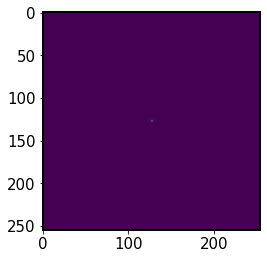

In [74]:
# OPD --> PSF --> OTF --> OTF' (OTF + atmosphere) --> PSF'
# Check with Bo that we could get OTF' or PSF' from PhoSim or not directly.
# The above question might not be a concern in the simulation.
# However, for the real image, it loooks like this is hard to do
# What should be the standard way to judge the PSSN in the real telescope?

# OPD is zero for perfect telescope
opdt = np.zeros((m, m))

# OPD to PSF
psft = MetroTool.opd2psf(
    opdt,
    iad,
    wlum,
    imagedelta=imagedelta,
    sensorFactor=1,
    fno=fno,
    debugLevel=debugLevel,
)
plt.imshow(psft)

Ideal PSF - almost can't notice!

In [75]:
# PSF to optical transfer function (OTF)
otft = MetroTool.psf2otf(psft)


After adding atmosphere the PSF is much more blurred:

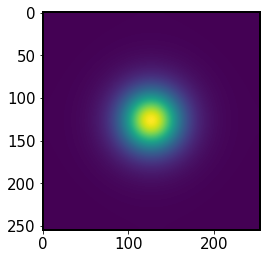

In [76]:
# Add atmosphere to perfect telescope
otfa = otft * mtfa

# OTF to PSF
psfa = MetroTool.otf2psf(otfa)

# Atmospheric PSS (point spread sensitivity) = 1/neff_atm
pssa = np.sum(psfa**2)
plt.imshow(psfa)

Calculate the PSF from the OPD data:

opd2psf(): imagedelta = 0.000000.0 means using OPD with padding as provided.
Verify psf has been normalized:  1.0.


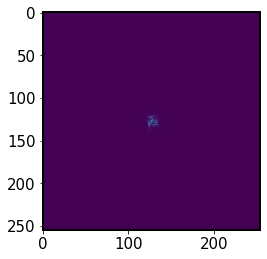

In [81]:
# Calculate PSF with error (atmosphere + system)
#if aType == "opd":

#if array.ndim == 2:
ninst = 1
#for ii in range(ninst):

#if array.ndim == 2:
array2D = array
#else:array2D = array[ii, :, :].squeeze()

psfei = MetroTool.opd2psf(array2D, iad, wlum, debugLevel=debugLevel)

#if ii == 0:
psfe = psfei
#else:
#    psfe += psfei

# Do the normalization based on the number of instrument
psfe = psfe / ninst
plt.imshow(psfe)

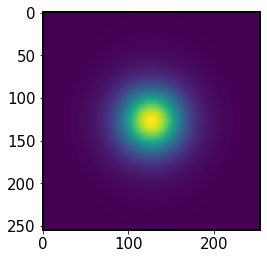

In [79]:
# OTF with system error
otfe = MetroTool.psf2otf(psfe)

# Add the atmosphere error
# OTF with system and atmosphere errors
otftot = otfe * mtfa

# PSF with system and atmosphere errors
psftot = MetroTool.otf2psf(otftot)
plt.imshow(psftot)

In [82]:
# atmospheric + error PSS
pss = np.sum(psftot**2)

# normalized PSS
pssn = pss / pssa
print(pssn)

0.9619065296118394


This is the final value of PSSN based on this OPD image, and is stored  as one of the elements of PSSN.txt 

Other notes : 

In [2]:
s = 0.35
np.sqrt(s**2+s**2)

0.49497474683058323

In [3]:
np.sqrt(0.49**2+0.6**2)

0.7746612162745725

In [4]:
np.sqrt(0.35**2+0.6**2)

0.6946221994724903

In [9]:
pssn = 0.99
eta = 1.086
FWHMatm = 0.6
FWHMeff = eta * FWHMatm * np.sqrt(1 / pssn - 1)
print(FWHMeff)

0.06548826404229048


In [1]:
pwd

'/project/scichris/aos/AOS'

In [2]:
a = None

In [3]:
a == None

True

In [4]:
a is None

True

We calculate  OPD (wavefront error) --> PSSN ---> FWHM . The FWHM is the FWHM_effective, i.e. FWHMeff = eta * FWHMatm * sqrt(1 / pssn - 1), with eta=1.086 and FWHMatm=0.6 arcsec ( https://github.com/lsst-ts/ts_phosim/blob/f55c6b27b1df4b8d0fbad541f9fb3b1934a57fd7/python/lsst/ts/phosim/OpdMetrology.py#L402-L430 ) .  I studied the SRD, and I see the 0.69'' design seeing requirement, which assumes 0.6'' atmospheric seeing, and 0.35'' telescope+camera seeing. 0.6 and 0.35 added in quadrature yields exactly 0.69. 